### LLM Initialize

In [1]:
from langchain_ollama.llms import OllamaLLM
from langchain_ollama.chat_models import ChatOllama
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

# llama3.2:3b-instruct-q8_0
# llama3-groq-tool-use:8b
llm = ChatOllama(model="llama3-groq-tool-use:8b", temperature=0)
llm

ChatOllama(model='llama3-groq-tool-use:8b', temperature=0.0)

### Tool Intialize

In [5]:
from langchain_core.tools import tool

class Piece:
    def __init__(self, color, value, is_dama=False):
        # self.row = row
        # self.col = column
        self.value = value
        self.index = None
        self.color = color
        self.is_dama = is_dama
        self.name = f"{color}, {value}"
        self.capture_index = {}

    def __repr__(self):
        return f"Piece({self.name}, is_dama={self.is_dama})"

    def __eq__(self, other):
        return isinstance(other, Piece) and self.name == other.name

    def __hash__(self):
        return hash(self.name)

# Define tools
@tool
def get_red_valid_moves(board_str: str) -> str:
    """
    Use this function to return valid moves of red piece in a board list.

    Args:
        board_str (str): string list representation of the board.

    Returns:
        str: JSON string valid moves of the board by position key pairs.
    """
    transformed_data = (board_str
        .replace('null', 'None')
        .replace('true', 'True')
        .replace('false', 'False')
        .replace('Piece(r,', "{'color': 'r', 'value':")
        .replace('Piece(b,', "{'color': 'b', 'value':")
        .replace(', isdama=True)', ", 'is_dama': True}")
        .replace(', isdama=False)', ", 'is_dama': False}")
        .replace("+']", '+]')
        .replace("'+]", '+]')
        .replace("+]", "'+']")
        .replace("-']", '-]')
        .replace("'-]", '-]')
        .replace("-]", "'-']")
        .replace("*']", '*]')
        .replace("'*]", '*]')
        .replace("*]", "'*']")
        .replace("/']", '/]')
        .replace("'/]", '/]')
        .replace("/]", "'/']")
    )

    transformed_data = eval(transformed_data)

    board = transformed_data

    valid_moves = {"valid_moves": []}
    has_mandatory_capture = False
    mandatory_moves = []

    def check_capture(index, piece, visited=None):
        if visited is None:
            visited = []

        captures = []
        directions = []

        if piece['is_dama']:
            directions = [
                {"step": 7, "movement": 7},
                {"step": 9, "movement": 9},
                {"step": -7, "movement": -7},
                {"step": -9, "movement": -9}
            ]
        else:
            if piece['color'] == 'r':
                directions = [
                    {"step": 7, "movement": 14},
                    {"step": 9, "movement": 18}
                ]

        for direction in directions:
            current_idx = index
            step = direction["step"]

            while True:
                capture_idx = current_idx + step
                if not (0 <= capture_idx < 64):
                    break

                if (isinstance(board[capture_idx], list) and
                    board[capture_idx][0] is not None and
                    board[capture_idx][0]['color'] != piece['color'] and
                    capture_idx not in visited):

                    landing_idx = capture_idx + step
                    landing_spots = []

                    while 0 <= landing_idx < 64:
                        if not isinstance(board[landing_idx], list):
                            break
                        if board[landing_idx][0] is not None:
                            break
                        landing_spots.append(landing_idx)
                        if not piece['is_dama']:
                            break
                        landing_idx += step

                    for landing in landing_spots:
                        new_visited = visited + [index, capture_idx]
                        next_captures = check_capture(landing, piece, new_visited)

                        if next_captures:
                            for capture_path in next_captures:
                                captures.append([landing] + capture_path)
                        else:
                            captures.append([landing])

                if not piece['is_dama']:
                    break
                current_idx += step
                if not (0 <= current_idx < 64):
                    break

        return captures

    def get_dama_moves(index, piece):
        moves = [[], [], [], []]
        directions = [(7, 0), (9, 1), (-9, 2), (-7, 3)]
        for step, dir_idx in directions:
            current = index
            while True:
                next_pos = current + step
                if (0 <= next_pos < 64 and
                    isinstance(board[next_pos], list) and
                    board[next_pos][0] is None):
                    moves[dir_idx].append(next_pos)
                    current = next_pos
                else:
                    break
        return moves

    for index, cell in enumerate(board):
        if isinstance(cell, list) and isinstance(cell[0], dict):
            piece = cell[0]
            if piece['color'] == 'r':
                captures = check_capture(index, piece)
                if captures:
                    has_mandatory_capture = True
                    mandatory_moves.append({
                        "position": [index, cell[1]],
                        "piece": ["red", piece['value'], piece['is_dama']],
                        "destination": captures
                    })

    if has_mandatory_capture:
        valid_moves = {"valid_captures": mandatory_moves}
    else:
        valid_moves["valid_moves"] = []
        for index, cell in enumerate(board):
            if isinstance(cell, list) and isinstance(cell[0], dict):
                piece = cell[0]
                if piece['color'] == 'r':
                    if piece['is_dama']:
                        dama_moves = get_dama_moves(index, piece)
                        move = {
                            "position": [index, cell[1]],
                            "piece": ["red", piece['value'], piece['is_dama']],
                            "destination": dama_moves
                        }
                        valid_moves["valid_moves"].append(move)
                    else:
                        possible_moves = []
                        for delta in [7, 9]:
                            next_pos = index + delta
                            if (next_pos < 64 and isinstance(board[next_pos], list) and
                                board[next_pos][0] is None):
                                possible_moves.append(next_pos)
                        if possible_moves:
                            move = {
                                "position": [index, cell[1]],
                                "piece": ["red", piece['value'], piece['is_dama']],
                                "destination": possible_moves
                            }
                            valid_moves["valid_moves"].append(move)

    return valid_moves





#### Run this to set llm with tools

In [ ]:
# Augment the LLM with tools
tools = [get_red_valid_moves]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)
llm_with_tools
# result = tools[0].invoke({"a":"2", "b":"4"})
# result
x = """[
    [None, '*'], 'X', [None, '/'], 'X', [None, '-'], 'X', [None, '+'], 'X', 'X',
    [None, '/'], 'X', [None, '*'], 'X', [Piece('r', -11, is_dama=False), '+'], 'X',
    [Piece('r', 0, is_dama=False), '-'], [None, '-'], 'X', [None, '+'], 'X', 
    [Piece('r', 6, is_dama=True), '*'], 'X', [Piece('r', -9, is_dama=False), '/'], 'X', 'X',
    [None, '+'], 'X', [None, '-'], 'X', [None, '/'], 'X', [None, '*'], [Piece('b', 0, is_dama=True), '*'], 'X',
    [None, '/'], 'X', [None, '-'], 'X', [None, '+'], 'X', 'X', [None, '/'], 'X',
    [None, '*'], 'X', [None, '+'], 'X', [None, '-'], [Piece('r', -5, is_dama=True), '-'], 'X',
    [None, '+'], 'X', [None, '*'], 'X', [None, '/'], 'X', 'X', [None, '+'], 'X',
    [None, '-'], 'X', [None, '/'], 'X', [None, '*']
]"""

tools_by_name["get_red_valid_moves"].invoke(x)

{'valid_moves': []}

### LangGraph


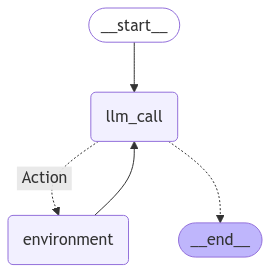

LLMCALL
{'messages': [HumanMessage(content="Get the red valid moves for this: [[None, '*'], 'X', [None, '/'], 'X', [None, '-'], 'X', [None, '+'], 'X', 'X', [None, '/'], 'X', [None, '*'], 'X', [{'color': 'r','value': -11, 'is_dama': False}, '+'], 'X', [{'color': 'r', 'value': 0, 'is_dama': False}, '-'], [None, '-'], 'X', [None, '+'], 'X',[{'color': 'r', 'value': 6, 'is_dama': True}, '*'], 'X', [{'color': 'r', 'value': -9, 'is_dama': False}, '/'], 'X', 'X', [None, '+'],'X', [None, '-'], 'X', [None, '/'], 'X', [None, '*'], [{'color': 'b', 'value': 0, 'is_dama': True}, '*'], 'X', [None, '/'], 'X',[None, '-'], 'X', [None, '+'], 'X', 'X', [None, '/'], 'X', [None, '*'], 'X', [None, '+'], 'X', [None, '-'], [{'color': 'r', 'value':-5, 'is_dama': True}, '-'], 'X', [None, '+'], 'X', [None, '*'], 'X', [None, '/'], 'X', 'X', [None, '+'], 'X', [None, '-'], 'X', [None,'/'], 'X', [None, '*']]", additional_kwargs={}, response_metadata={}, id='3fd5c55a-79bc-4937-b221-51808c472b9f')]}
Ho
{'messages': [Hu

In [ ]:
from langgraph.graph import MessagesState
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""
    print("LLMCALL")
    print(state)
    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing the necessary tool call needed depending on the input."
                    )
                ]
                + state["messages"]
            )
        ]
    }

def llm_convert(state: MessagesState):
    """LLM converts a message into an appropriate format"""
    print(state)
    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with converting the last message with the required format."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""
    print("TOOL CALL")
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""
    print("Ho")
    print(state)
    print("state ^^^")
    messages = state["messages"]
    last_message = messages[-1]
    print("last message", type(last_message), last_message)
    # print(last_message.tool_calls)
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    print("\n\n\nMANA\n\n\n")
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

x = """[
    [None, '*'], 'X', [None, '/'], 'X', [None, '-'], 'X', [None, '+'], 'X', 'X',
    [None, '/'], 'X', [None, '*'], 'X', Piece('r', -11, is_dama=False), 'X',
    Piece('r', 0, is_dama=False), [None, '-'], 'X', [None, '+'], 'X',
    Piece('r', 6, is_dama=True), 'X', Piece('r', -9, is_dama=False), 'X', 'X',
    [None, '+'], 'X', [None, '-'], 'X', [None, '/'], 'X', [None, '*'],
    Piece('b', 0, is_dama=True), 'X', [None, '/'], 'X', [None, '-'], 'X', [None, '+'],
    'X', 'X', [None, '/'], 'X', [None, '*'], 'X', [None, '+'], 'X', [None, '-'],
    Piece('r', -5, is_dama=True), 'X', [None, '+'], 'X', [None, '*'], 'X', [None, '/'],
    'X', 'X', [None, '+'], 'X', [None, '-'], 'X', [None, '/'], 'X', [None, '*']
]"""
# Invoke
messages = [HumanMessage(content=f"Get the red valid moves for this: {x}")]
messages = agent.invoke({"messages": messages})
# for m in messages["messages"]:
#     m.pretty_print()
print("last line sa ubos ani")
print(messages)
print("\nLast message is:", messages["messages"][-1].content)

In [5]:
# from langgraph.prebuilt import create_react_agent

# # Pass in:
# # (1) the augmented LLM with tools
# # (2) the tools list (which is used to create the tool node)
# pre_built_agent = create_react_agent(llm, tools=tools)

# # Show the agent
# display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

# # Invoke
# messages = [HumanMessage(content="Add 3 and 4.")]
# messages = pre_built_agent.invoke({"messages": messages})
# for m in messages["messages"]:
#     m.pretty_print()